In [ ]:
# Q&A chatbots uses a technique know as RAG( Retireival Augumented Generation)

https://python.langchain.com/v0.2/docs/tutorials/rag/

RAG is a technique for augmenting LLM knowledge with additional data. LLLM's can reason on wide topics but knowledge is limited to the public data till a time point. we need to reason on private data. process of bringing the appropriate info and inserting into the model prompt is RAG

### Concepts

A typical RAG application has two main components:

`Indexing`: a pipeline for ingesting data from a source and indexing it. This usually happens offline.

`Retrieval and generation`: the actual RAG chain, which takes the user query at run time and retrieves the relevant data from the index, then passes that to the model.

#### Indexing

1. `Load`: First we need to load our data. This is done with DocumentLoaders.
2. `Split`: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and for passing it in to a model, since large chunks are harder to search over and won't fit            in  a  model's finite context window.
3. `Store`: We need somewhere to store and index our splits, so that they can later be searched over. This is often done using a VectorStore and Embeddings model.

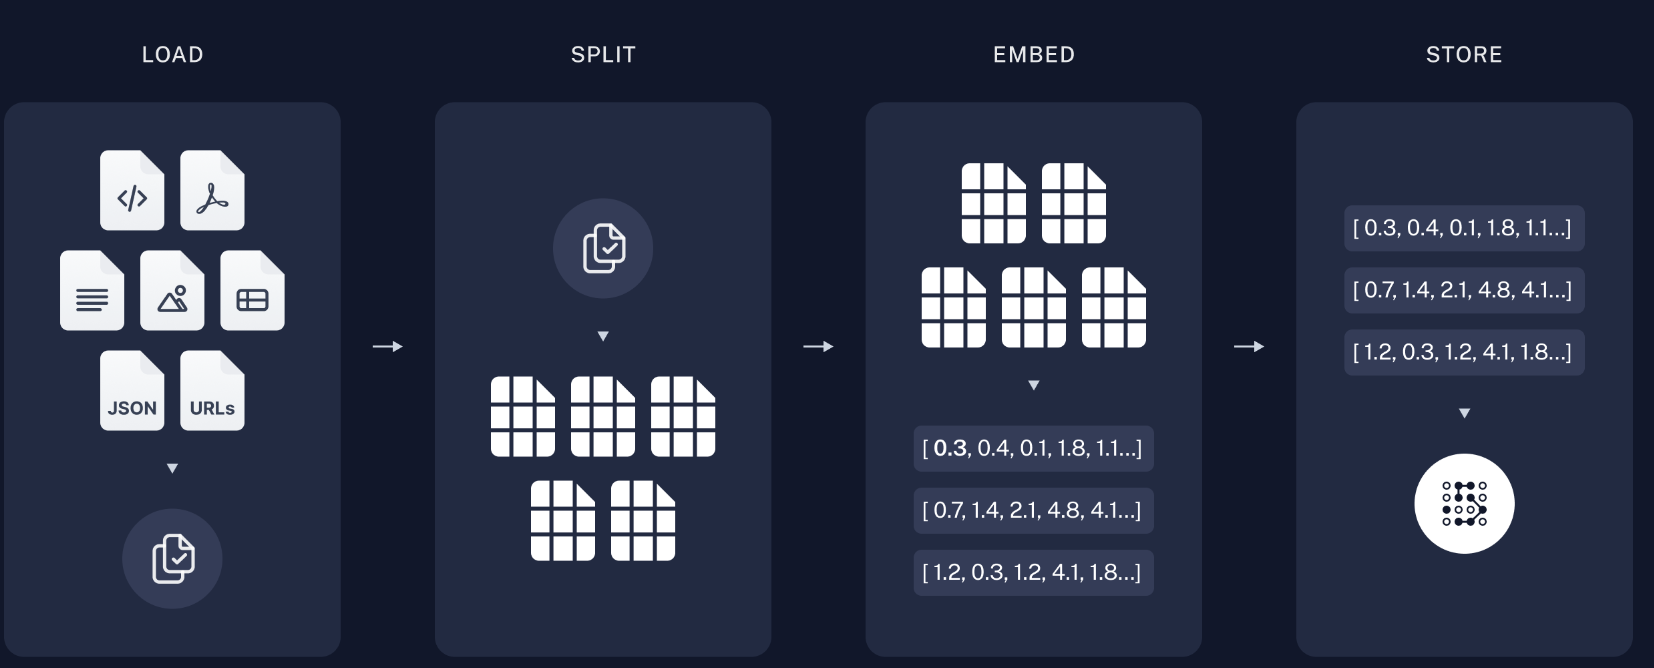

#### Retreiver and Generation

4. `Retrieve`: Given a user input, relevant splits are retrieved from storage using a Retriever.
5. `Generate`: A ChatModel / LLM produces an answer using a prompt that includes the question and the retrieved data

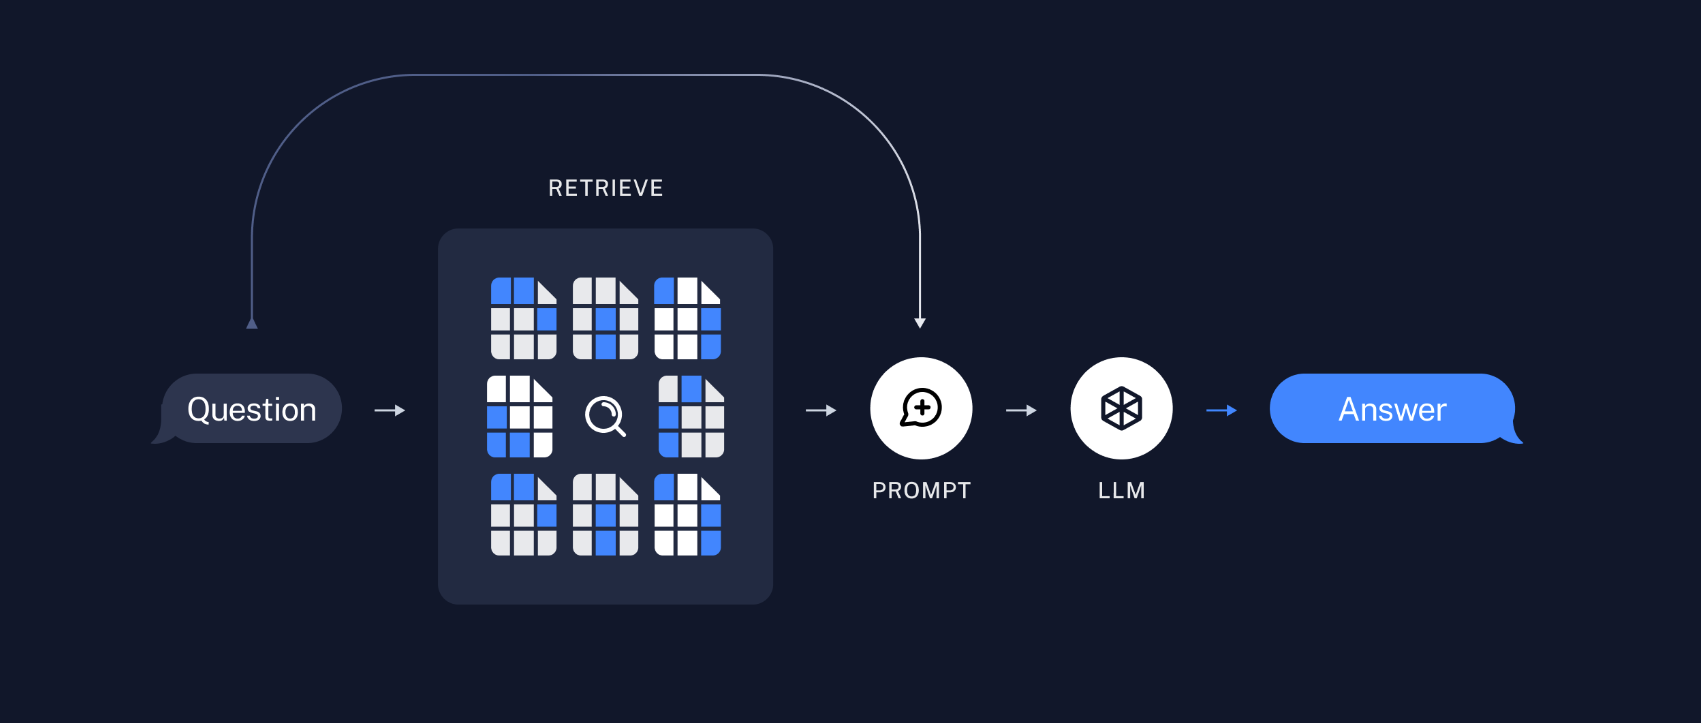

### Code

In [9]:
# # ! pip install bs4
# ! pip install langchainhub
# ! pip install langchain_text_splitters

In [10]:
from dotenv import load_dotenv
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
load_dotenv()

from langchain_openai import ChatOpenAI
model = ChatOpenAI(model = "gpt-3.5-turbo")

In [11]:
import bs4
from langchain_chroma import Chroma
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load, chunk and index the contents of the blog.
loader = WebBaseLoader(  # using DocumnetLoaders which are objects that  load data from source and return a list of Documents(page content , meta data) 
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",), 
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(class_=("post-content", "post-title", "post-header"))  #select only the specific HTML tag data classes
    ),
)
docs = loader.load()

# model struggules to find information in very long inputs  , so document in split into chunks

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200 , add_start_index = True) # character index at which each split document starts within the doc is preserved
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Retrieve and generate using the relevant snippets of the blog.
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

"Task Decomposition is a technique that breaks down complex tasks into smaller and simpler steps for easier processing. It involves transforming big tasks into multiple manageable tasks to aid in the interpretation of the model's thinking process. Methods like Chain of Thought and Tree of Thoughts are used to enhance model performance by exploring multiple reasoning possibilities at each step."

#### Document loaders:
1. Docs : https://python.langchain.com/v0.2/docs/how_to/#document-loaders
2. Integrations : https://python.langchain.com/v0.2/docs/integrations/document_loaders/
3. Interface : https://api.python.langchain.com/en/latest/document_loaders/langchain_core.document_loaders.base.BaseLoader.html

In [12]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

len(docs[0].page_content)

43131

In [17]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

66

In [20]:
len(all_splits[10].page_content) , all_splits[10].metadata

(412,
 {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
  'start_index': 7056})

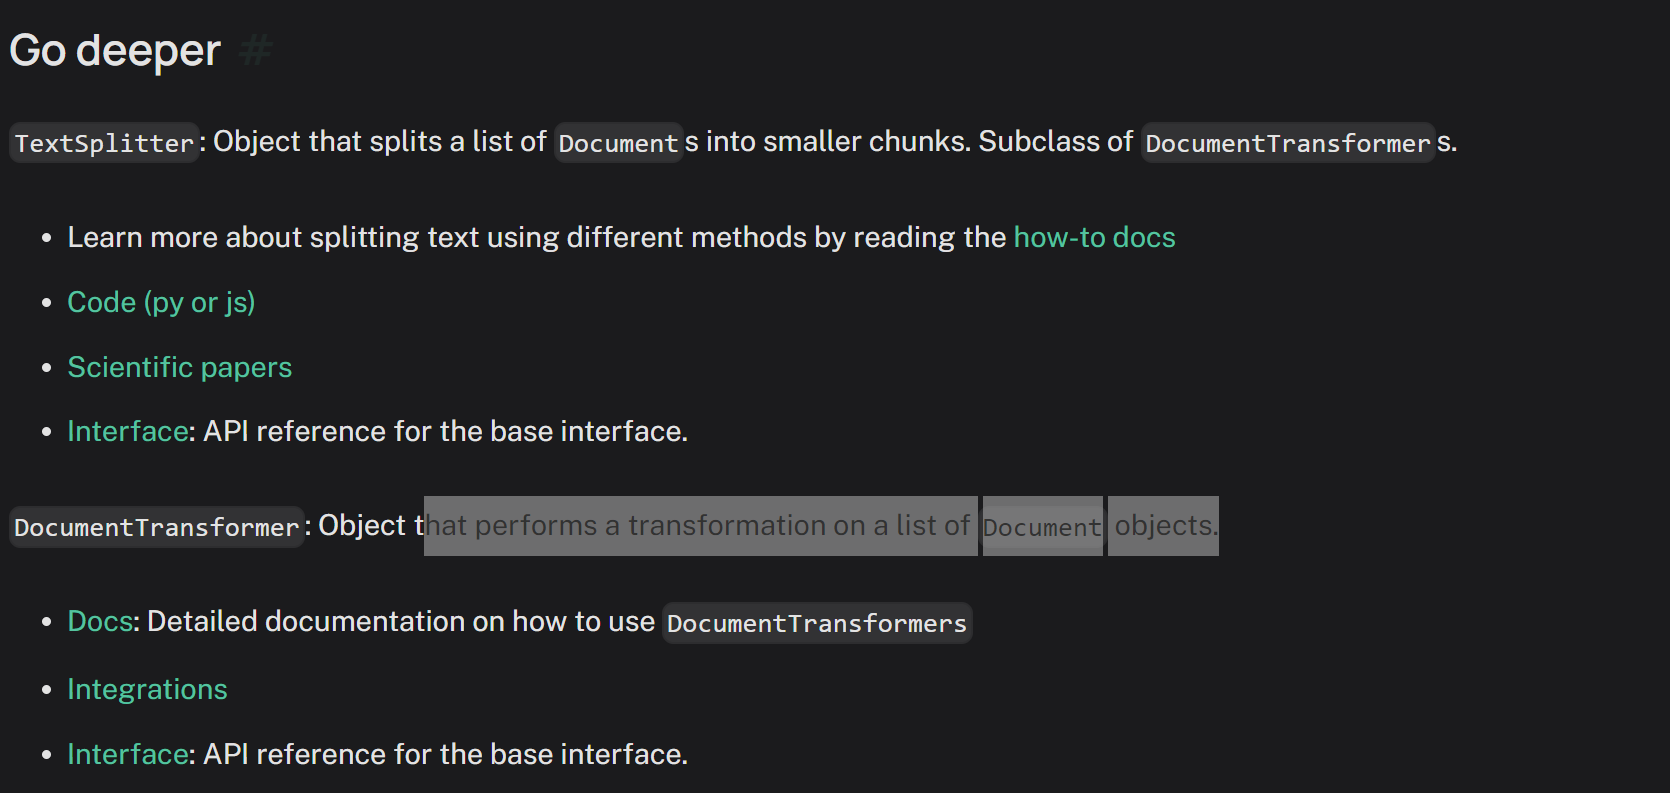

In [21]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(documents=all_splits, embedding=OpenAIEmbeddings())

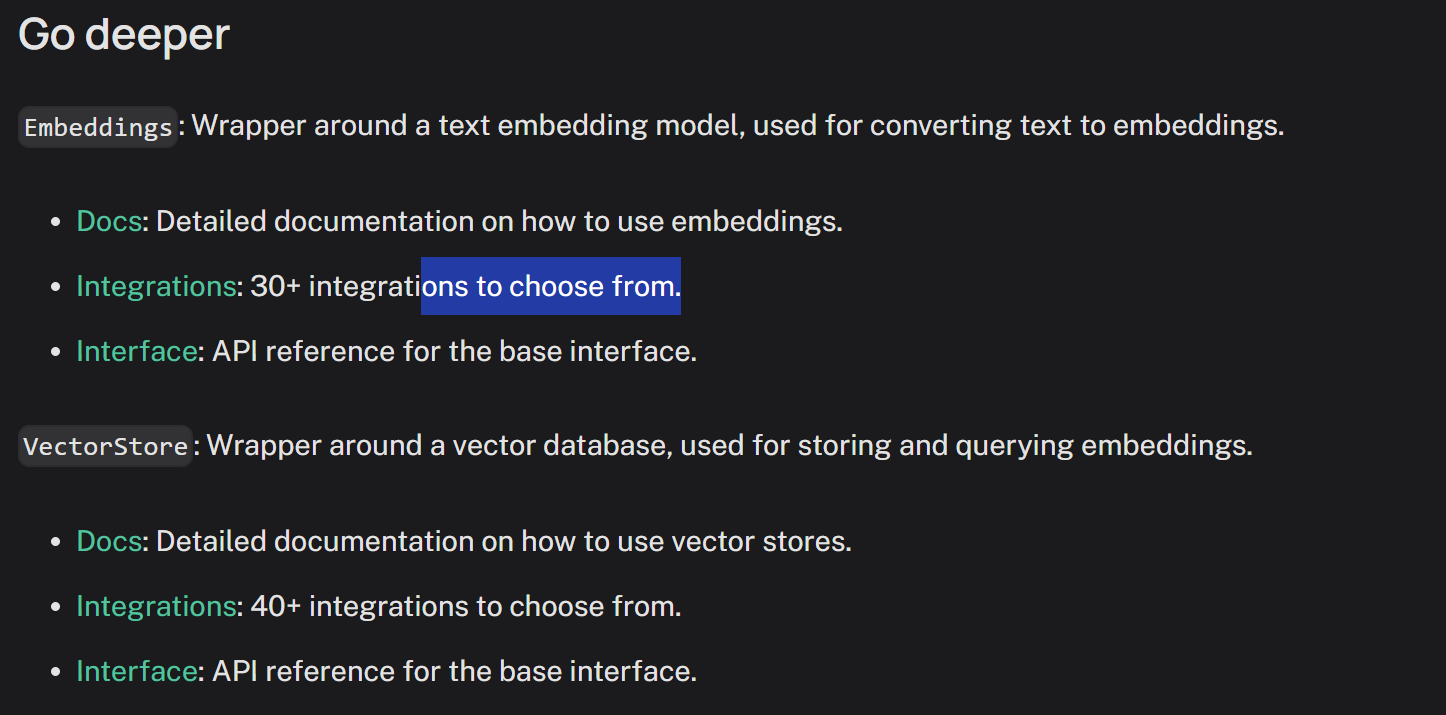

In [23]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

retrieved_docs = retriever.invoke("What are the approaches to Task Decomposition?")

len(retrieved_docs), print(retrieved_docs[0].page_content)

Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.


(6, None)

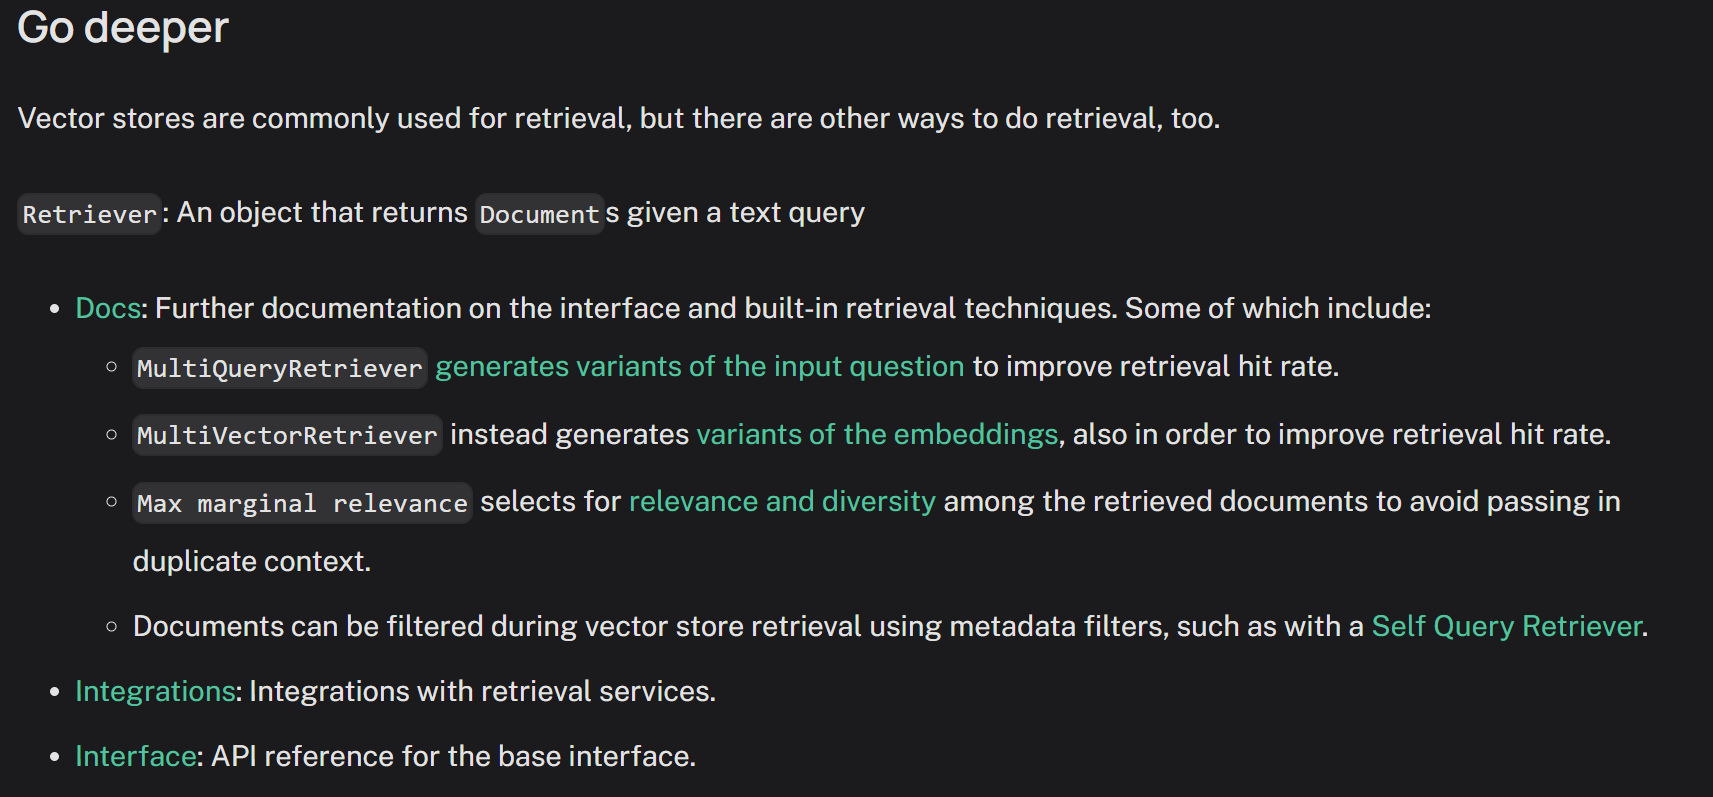

In [24]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "filler context", "question": "filler question"}
).to_messages()

example_messages

[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: filler question \nContext: filler context \nAnswer:")]

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

for chunk in rag_chain.stream("What is Task Decomposition?"):
    print(chunk, end="", flush=True)

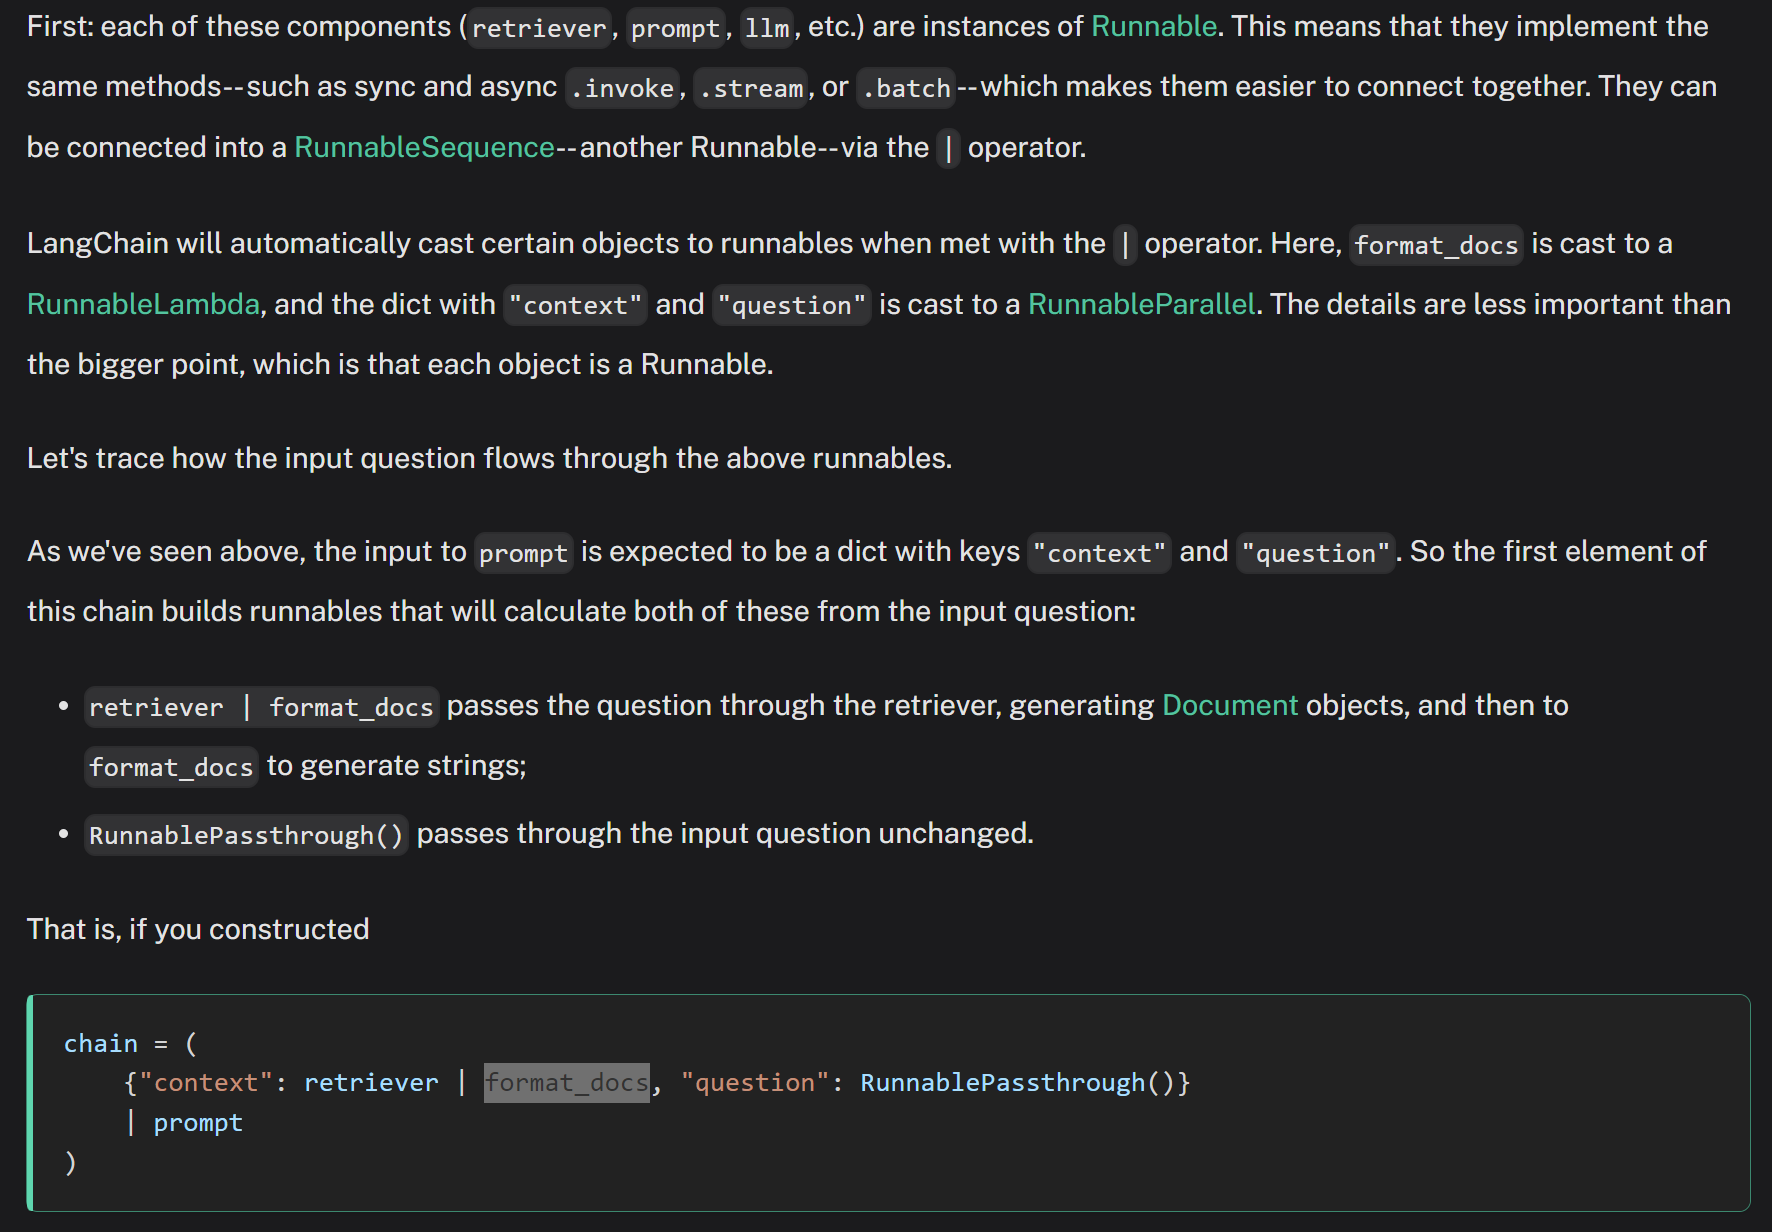

### BUILT IN : CHAINS

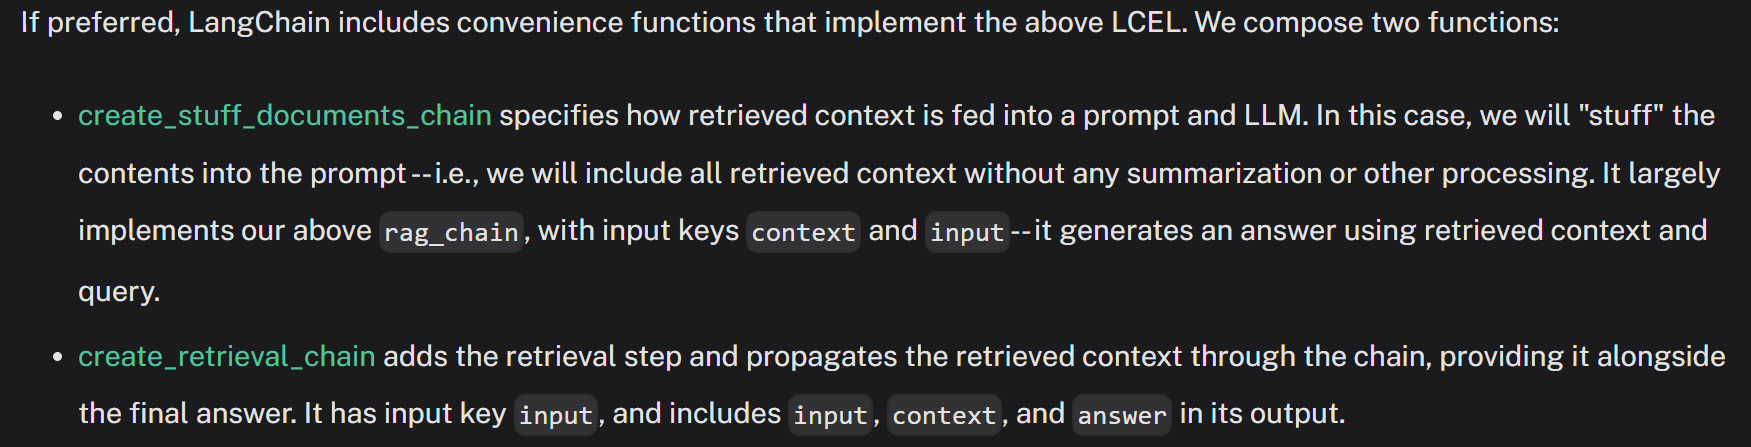

In [26]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(model, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

response = rag_chain.invoke({"input": "What is Task Decomposition?"})
print(response["answer"])

Task decomposition involves breaking down a complex task into smaller and simpler steps to make it more manageable. Techniques like Chain of Thought (CoT) and Tree of Thoughts extend this concept by guiding models to think step by step or explore multiple reasoning possibilities at each step. Task decomposition can be facilitated by using simple prompts, task-specific instructions, or human inputs.


In [27]:
for document in response["context"]:
    print(document)
    print()

page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.' metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}

page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting te

### Customized RAG Prompt 

In [28]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | custom_rag_prompt
    | model
    | StrOutputParser()
)

rag_chain.invoke("What is Task Decomposition?")

'Task decomposition is a method used to break down complex tasks into smaller and simpler steps to facilitate problem-solving and decision-making processes. This approach allows for a more manageable way of approaching difficult tasks by dividing them into more understandable components. Thanks for asking!'